### *Universit√© Nationale du Vietnam*  
### *Universit√© de La Rochelle*  

---

#### **Travail Pratique du Cours : Indexation de Contenu Multim√©dia**  

---

#####  **Groupe 3 :**  
### - **LUTALA LUSHULI David**  
### - **NZAZI NGABILA Boaz**


#### **Lien vers l'application** : https://github.com/DavidLUTALA/Indexation_Contenu_Multim-dia.git
---

### *Ann√©e acad√©mique : 2024 ‚Äì 2025*
---

# Introduction

Ce notebook pr√©sente la mise en ≈ìuvre d‚Äôun syst√®me d‚Äôindexation et de recherche de documents bas√© sur l'ind√©xation utilisant les techniques de la vision par ordinateur.  
L‚Äôobjectif est de retrouver automatiquement, √† partir d‚Äôune vid√©o contenant une portion de texte, le document source dans une base d‚Äôimages.

Pour cela, nous combinons deux approches compl√©mentaires :
- Extraction de keypoints et de leurs descripteurs
- Indexation et recherche du document le plus similaire.

Le projet se termine par la localisation de la zone de texte dans le document reconnu, visualis√©e par projection g√©om√©trique √† l‚Äôaide d‚Äôune homographie.

Pour ce faire, nous suivons un pipeline structur√© de la mani√®re suivante :
1. **Chargement de la base de documents**  
   - Lecture des images de r√©f√©rence (base d'images).  
   - Extraction des keypoints et descripteurs SIFT.  
   - Calcul du hash perceptuel (dHash) pour chaque keypoint de l'image.

2. **T√©l√©versement de la vid√©o requ√™te**  
   - Extraction de la frame centrale.  
   - D√©tection des keypoints SIFT de la frame.  
   - Calcul du hash de la frame.

3. **Filtrage rapide par hachage (dHash)**  
   - Calcul des distances de hachage entre la frame et chaque image de la base.  
   - S√©lection des 30 images les plus proches.

4. **Matching SIFT pour affiner la recherche**  
   - Appariement des descripteurs SIFT entre la frame et les 30 images filtr√©es.  
   - Identification de l‚Äôimage avec le plus grand nombre de bons matchs.

5. **Localisation de la zone de texte**  
   - Estimation de l‚Äôhomographie entre la frame et l‚Äôimage reconnue.  
   - Projection de la zone d√©tect√©e dans l‚Äôimage finale (encadr√©e en vert ou bleu).

### √âtape 0 : Importation de Bibliotheques 

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import imagehash

### √âtape 1 : Fonction de Hachage

- Cette fonction calcule le hachage perceptuel (dHash) d‚Äôune image.  
- Elle convertit d‚Äôabord l‚Äôimage en niveaux de gris, la redimensionne √† 9x8 pixels.  
- Puis elle compare chaque pixel avec son voisin de droite pour g√©n√©rer un hash binaire de 64 bits, exprim√© en hexad√©cimal.

In [21]:
import cv2
import numpy as np

def compute_dhash(image, hash_size=8):
    """
    Calcule un dHash (difference hash) 64 bits pour une image BGR (OpenCV).
    √âtapes :
    1. Convertir en niveaux de gris
    2. Redimensionner √† (hash_size + 1, hash_size) => par d√©faut : (9,8)
    3. Comparer chaque pixel √† son voisin de droite
    4. Construire un hash binaire puis hexad√©cimal
    """
    # √âtape 1 : Convertir en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # √âtape 2 : Redimensionner √† (9, 8) pour obtenir 8x8 diff√©rences horizontales
    resized = cv2.resize(gray, (hash_size + 1, hash_size))

    # √âtape 3 : Calcul des diff√©rences gauche > droite ?
    diff = resized[:, 1:] > resized[:, :-1]

    # √âtape 4 : Construction du hash binaire en nombre entier
    dhash_value = 0
    for i, val in enumerate(diff.flatten()):
        if val:
            dhash_value |= 1 << (len(diff.flatten()) - 1 - i)

    # Conversion finale du hash en hexad√©cimal
    return f"{dhash_value:016x}"


### Cette fonction permet d'appeler simplement le hachage d'une image en BGR.  
- Elle utilise la fonction compute_dhash pour retourner le hash de l‚Äôimage.

In [22]:
def compute_image_hash(image_bgr):
    return compute_dhash(image_bgr)

### √âtape 3 : Chargement des images et extraction SIFT

- Cette √©tape consiste √† parcourir toutes les images de la base pour en extraire les informations n√©cessaires.  
- Chaque image est convertie en niveaux de gris pour en extraire les points cl√©s et descripteurs SIFT.  
- Un hash dHash est √©galement calcul√© pour chaque image afin de permettre une comparaison rapide par hachage.  
- Les r√©sultats sont stock√©s dans un dictionnaire incluant l'image, ses keypoints, descripteurs et son hash.


In [36]:
import cv2
import numpy as np
import os
from PIL import Image

# === Fonction de hachage dHash ===
def compute_dhash(image, hash_size=8):
    """
    Calcule un dHash (difference hash) 64 bits pour une image BGR (OpenCV).
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (hash_size + 1, hash_size))
    diff = resized[:, 1:] > resized[:, :-1]

    dhash_value = 0
    for i, val in enumerate(diff.flatten()):
        if val:
            dhash_value |= 1 << (len(diff.flatten()) - 1 - i)

    return f"{dhash_value:016x}"  # Hash sous forme de string hexad√©cimale (64 bits)

# === Fonction utilisateur pour appel standardis√© ===
def compute_image_hash(image_bgr):
    return compute_dhash(image_bgr)

# === Cr√©ation de l'objet SIFT ===
sift = cv2.SIFT_create()

# === Dictionnaire pour stocker les donn√©es de la base ===
base_descripteurs = {}

# === Dossier contenant les images ===
image_folder = "images"

# === Parcours des fichiers image ===
for filename in os.listdir(image_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_path = os.path.join(image_folder, filename)
        img = cv2.imread(img_path)

        if img is None:
            print(f" Erreur de lecture pour {filename}")
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Extraction des keypoints/descripteurs
        keypoints, descriptors = sift.detectAndCompute(gray, None)

        # Calcul du hash dHash
        img_hash = compute_image_hash(img)

        # Stockage dans la base
        base_descripteurs[filename] = {
            "image": img,
            "keypoints": keypoints,
            "descriptors": descriptors,
            "hash": img_hash
        }

        print(f" {filename} : {len(keypoints)} keypoints d√©tect√©s ‚Äì Hash : {img_hash}")


 0001.jpg : 12364 keypoints d√©tect√©s ‚Äì Hash : 0000100410001001
 0002.jpg : 5713 keypoints d√©tect√©s ‚Äì Hash : 0001026010000000
 0004.jpg : 28933 keypoints d√©tect√©s ‚Äì Hash : 0055005428404800
 0006.jpg : 26246 keypoints d√©tect√©s ‚Äì Hash : 0012001012494a00
 0007.jpg : 20488 keypoints d√©tect√©s ‚Äì Hash : 00000a1c50404908
 0008.jpg : 437 keypoints d√©tect√©s ‚Äì Hash : 0000020000000000
 0010.jpg : 22839 keypoints d√©tect√©s ‚Äì Hash : 0000240020121d00
 0013.jpg : 16057 keypoints d√©tect√©s ‚Äì Hash : 8401006040550101
 0015.jpg : 6395 keypoints d√©tect√©s ‚Äì Hash : 2240422002000000
 0016.jpg : 18396 keypoints d√©tect√©s ‚Äì Hash : 6822151d4a450040
 0017.jpg : 9931 keypoints d√©tect√©s ‚Äì Hash : 0020004b00000000
 0020.jpg : 7569 keypoints d√©tect√©s ‚Äì Hash : 0100000010000000
 0021.jpg : 17013 keypoints d√©tect√©s ‚Äì Hash : 0040092210000002
 0022.jpg : 7424 keypoints d√©tect√©s ‚Äì Hash : 4004003000404000
 0023.jpg : 13039 keypoints d√©tect√©s ‚Äì Hash : 808480b0a4883900
 0

### √âtape 4 : Charger une vid√©o et extraire une frame au milieu

- La vid√©o est charg√©e depuis le dossier `requetes` √† l‚Äôaide d‚ÄôOpenCV.  
- On v√©rifie l‚Äôouverture correcte du fichier, sinon un message d‚Äôerreur s‚Äôaffiche.  

- La frame centrale est extraite puis convertie en niveaux de gris.  
- Cela pr√©pare l‚Äôimage √† l‚Äôextraction des descripteurs SIFT.  

- Les keypoints et descripteurs SIFT sont extraits de la frame.  
- Le hachage dHash est calcul√© pour obtenir une signature visuelle.  

- La frame est affich√©e avec les keypoints d√©tect√©s.  
- Le nombre de points et le hash sont imprim√©s pour v√©rification.

 Frame extraite avec 9543 keypoints ‚Äì Hash : e4d0c890e0919187


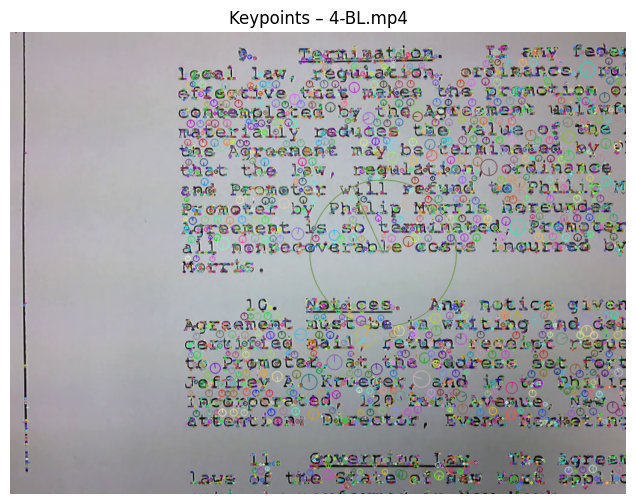

In [37]:
import matplotlib.pyplot as plt

# === √âtape 2 : Chargement et traitement d'une vid√©o requ√™te ===

# Nom de la vid√©o √† tester
video_name = "4-BL.mp4"  # Remplace par un autre nom si n√©cessaire
video_path = os.path.join("requetes", video_name)

# Lecture de la vid√©o
cap = cv2.VideoCapture(video_path)

# V√©rification de l'ouverture
if not cap.isOpened():
    print(" Impossible d‚Äôouvrir la vid√©o.")
else:
    # Extraction de la frame centrale
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    mid_frame_idx = frame_count // 2
    cap.set(cv2.CAP_PROP_POS_FRAMES, mid_frame_idx)

    ret, frame = cap.read()
    cap.release()

    if not ret:
        print(" Impossible d‚Äôextraire la frame de la vid√©o.")
    else:
        # Conversion en niveaux de gris
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Extraction des keypoints et descripteurs SIFT
        kp_frame, des_frame = sift.detectAndCompute(gray_frame, None)

        # Calcul du hash de la frame avec dHash
        frame_hash = compute_image_hash(frame)

        # R√©sum√© des r√©sultats
        print(f" Frame extraite avec {len(kp_frame)} keypoints ‚Äì Hash : {frame_hash}")

        # Affichage de la frame avec les keypoints
        img_kp = cv2.drawKeypoints(frame, kp_frame, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
        plt.title(f"Keypoints ‚Äì {video_name}")
        plt.axis("off")
        plt.show()


### √âtape 5 : Filtrage rapide par hachage (top 30)

- On v√©rifie que la variable `frame_hash` existe, c‚Äôest-√†-dire que la vid√©o a bien √©t√© trait√©e avant.  
- Le code calcule la distance entre le hash de la frame vid√©o et celui de chaque image de la base.  
- Ces distances sont tri√©es pour identifier les 30 images les plus proches visuellement.  
- On utilise la distance de Hamming entre les hash dHash pour cette mesure de similarit√©.  
- La liste des 30 images les plus similaires est ensuite affich√©e avec leur distance respective.

In [39]:
# === √âtape 3 : Filtrage rapide par hachage dHash (top 15) ===

# V√©rification pr√©alable
if "frame_hash" not in locals():
    print(" Vous devez d'abord extraire une frame de la vid√©o (√âtape 2).")
else:
    # Calcul des distances de hachage (distance de Hamming entre les hash hex)
    hash_distances = {
        name: abs(int(data["hash"], 16) - int(frame_hash, 16))
        for name, data in base_descripteurs.items()
    }

    # S√©lection des top 30 images les plus proches
    top_k = 30
    top_k_hashes = sorted(hash_distances.items(), key=lambda x: x[1])[:top_k]

    # Affichage
    print(" Top 30 images les plus proches par hachage (dHash) :")
    for rank, (name, dist) in enumerate(top_k_hashes, 1):
        print(f"{rank:02d}.  {name} ‚Äì Distance de hachage : {dist}")

 Top 30 images les plus proches par hachage (dHash) :
01.  0045.jpg ‚Äì Distance de hachage : 6677772342539915655
02.  0013.jpg ‚Äì Distance de hachage : 6976014458992496774
03.  0023.jpg ‚Äì Distance de hachage : 7227230530428295303
04.  0057.jpg ‚Äì Distance de hachage : 7244752926012838279
05.  0016.jpg ‚Äì Distance de hachage : 8984315615674929479
06.  0033.jpg ‚Äì Distance de hachage : 9570369732730786183
07.  0035.jpg ‚Äì Distance de hachage : 11587419106596437895
08.  0028.jpg ‚Äì Distance de hachage : 11803589761364496775
09.  0022.jpg ‚Äì Distance de hachage : 11875086635874996615
10.  0041.jpg ‚Äì Distance de hachage : 12735269972818891143
11.  0015.jpg ‚Äì Distance de hachage : 14019853459332895111
12.  0036.jpg ‚Äì Distance de hachage : 14181998559373660551
13.  0030.jpg ‚Äì Distance de hachage : 14182055751155470726
14.  0027.jpg ‚Äì Distance de hachage : 14735954274677789063
15.  0052.jpg ‚Äì Distance de hachage : 15839218712790012295
16.  0049.jpg ‚Äì Distance de hachage

### √âtape 6 : Recherche du document le plus similaire (matching SIFT)

- Cette √©tape compare la frame extraite aux 30 images filtr√©es √† l‚Äôaide de l‚Äôalgorithme SIFT.  
- Pour chaque image, on applique le ratio de Lowe pour identifier les bons appariements.  
- Le nombre de bons matchs est stock√© pour chaque image afin d‚Äô√©valuer leur similarit√©.  
- L‚Äôimage avec le plus grand nombre de correspondances est s√©lectionn√©e comme document correspondant.  
- On r√©cup√®re ensuite ses keypoints, descripteurs et l‚Äôimage elle-m√™me pour l‚Äô√©tape de localisation.

In [ ]:
# === √âtape 6 : Matching SIFT sur les top 50 documents filtr√©s par hachage ===

# Initialisation du matcher SIFT
bf = cv2.BFMatcher(cv2.NORM_L2)

# Dictionnaire pour stocker le nombre de bons matchs SIFT
scores = {}

# Comparaison de la frame extraite avec chaque image du top 30
for name, _ in top_k_hashes:
    des_img = base_descripteurs[name]["descriptors"]
    if des_img is not None and des_frame is not None:
        matches = bf.knnMatch(des_frame, des_img, k=2)
        # Ratio de Lowe : filtre les bons matchs
        good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
        scores[name] = len(good_matches)
        print(f" {name} ‚Äì {len(good_matches)} bons matchs SIFT")

# S√©lection de l'image avec le plus grand nombre de bons matchs
best_match = max(scores, key=scores.get)
nb_best_matches = scores[best_match]

print(f"\n Document le plus similaire : {best_match} avec {nb_best_matches} bons matchs")

# R√©cup√©ration des donn√©es de l'image reconnue
best_img = base_descripteurs[best_match]["image"]
kp_img = base_descripteurs[best_match]["keypoints"]
des_img = base_descripteurs[best_match]["descriptors"]

 0045.jpg ‚Äì 408 bons matchs SIFT
 0013.jpg ‚Äì 170 bons matchs SIFT
 0023.jpg ‚Äì 217 bons matchs SIFT
 0057.jpg ‚Äì 439 bons matchs SIFT
 0016.jpg ‚Äì 290 bons matchs SIFT
 0033.jpg ‚Äì 324 bons matchs SIFT
 0035.jpg ‚Äì 398 bons matchs SIFT
 0028.jpg ‚Äì 338 bons matchs SIFT
 0022.jpg ‚Äì 245 bons matchs SIFT
 0041.jpg ‚Äì 169 bons matchs SIFT
 0015.jpg ‚Äì 544 bons matchs SIFT
 0036.jpg ‚Äì 404 bons matchs SIFT
 0030.jpg ‚Äì 192 bons matchs SIFT
 0027.jpg ‚Äì 216 bons matchs SIFT
 0052.jpg ‚Äì 208 bons matchs SIFT
 0049.jpg ‚Äì 280 bons matchs SIFT
 0056.jpg ‚Äì 199 bons matchs SIFT
 0044.jpg ‚Äì 249 bons matchs SIFT
 0029.jpg ‚Äì 380 bons matchs SIFT
 0031.jpg ‚Äì 271 bons matchs SIFT
 0032.jpg ‚Äì 229 bons matchs SIFT
 0020.jpg ‚Äì 356 bons matchs SIFT
 0043.jpg ‚Äì 328 bons matchs SIFT
 0004.jpg ‚Äì 1395 bons matchs SIFT
 0055.jpg ‚Äì 166 bons matchs SIFT
 0021.jpg ‚Äì 249 bons matchs SIFT
 0042.jpg ‚Äì 190 bons matchs SIFT
 0024.jpg ‚Äì 202 bons matchs SIFT
 0017.jpg ‚Äì 323 b

### √âtape 7 : Localiser la Zone du Texte dans le Document

- Cette √©tape utilise les bons matchs SIFT pour estimer une homographie entre la frame vid√©o et l‚Äôimage document.  
- Une fois l‚Äôhomographie calcul√©e, un polygone est projet√© pour repr√©senter la position du texte d√©tect√© dans le document.  
- La zone localis√©e est d√©limit√©e sur l‚Äôimage par un polygone trac√© en bleu.  
- Si le nombre de correspondances est insuffisant, la localisation n‚Äôest pas effectu√©e.

c:\Users\Sam Nzazi\Pictures\TP2_Indexation\env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


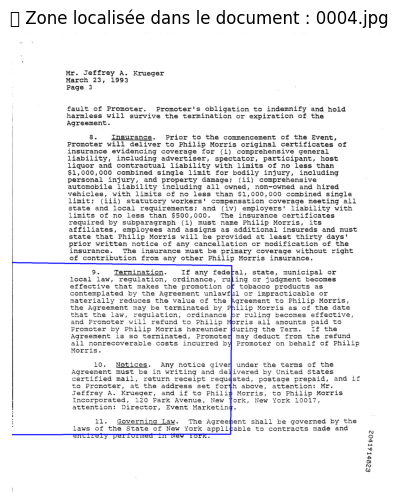

In [41]:
# === √âtape 7 : Localiser la zone du texte dans l‚Äôimage document ===

# Recalcule les bons matchs entre la frame vid√©o et l'image reconnue
matches = bf.knnMatch(des_frame, des_img, k=2)
good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

# V√©rifie qu'on a assez de correspondances pour estimer une homographie
if len(good_matches) >= 10:
    # Extraction des points correspondants
    src_pts = np.float32([kp_frame[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_img[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Estimation de la matrice d'homographie
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Dimensions de la frame requ√™te
    h_frame, w_frame = gray_frame.shape

    # Rectangle source (contour de la frame requ√™te)
    rect = np.float32([[0, 0], [w_frame, 0], [w_frame, h_frame], [0, h_frame]]).reshape(-1, 1, 2)

    # Transformation de ce rectangle dans l'image document
    projected = cv2.perspectiveTransform(rect, H)

    # Copie de l'image document pour affichage
    img_localised = best_img.copy()

    # Dessin du polygone vert
    img_localised = cv2.polylines(img_localised, [np.int32(projected)], isClosed=True, color=(255, 0, 0), thickness=3)

    # Affichage du r√©sultat
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(img_localised, cv2.COLOR_BGR2RGB))
    plt.title(f"üìç Zone localis√©e dans le document : {best_match}")
    plt.axis("off")
    plt.show()

else:
    print(" Pas assez de bons matchs pour localiser le texte dans le document.")

### ‚úÖ Conclusion du TP : Indexation et Localisation d‚Äôun Texte

Ce TP nous a permis de concevoir un syst√®me combinant hachage perceptuel (dHash) et descripteurs SIFT pour retrouver un document √† partir d‚Äôune vid√©o.

La frame centrale de la vid√©o est compar√©e √† une base d‚Äôimages : d‚Äôabord via un filtrage rapide par hachage, puis par appariement SIFT plus pr√©cis.

Le document le plus similaire est identifi√©, et une homographie permet de localiser la zone du texte dans l‚Äôimage.  
Ce processus montre l‚Äôefficacit√© de l‚Äôapproche pour rep√©rer automatiquement un contenu visuel pertinent.